# H-matrix compression example with Boundary Element Method

In this notebook we will test the compression of the double layer BEM operator for the Helmholtz equation on a ribcage mesh.

In [1]:
import numpy as np
import bempp.api
from time import time
import MyHM.structures as stt
from MyHM.compression.aca import ACAPP

# Plots:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

First, we load the mesh to be used:

In [2]:
grid = bempp.api.import_grid('grids/ribcage3-h-1.msh')

print("Vertices shape:", grid.vertices.shape)
print("Elements shape:", grid.elements.shape)


Vertices shape: (3, 8652)
Elements shape: (3, 17292)


We can plot the grid:

In [5]:
# grid.plot()

![](Images/ribcage3-h-1.png)
<!-- ![](https://github.com/ShescBlank/MyHM/blob/main/Images/ribcage3-h-1.png) -->

Next, we must construct the trees associated with the hierarchical matrices:

In [4]:
bbox = grid.bounding_box
vertices = grid.vertices
space = bempp.api.function_space(grid, "P", 1) # P1 elements
dof_indices = list(range(vertices.shape[1]))

octree = stt.Octree(vertices.T, dof_indices, bbox, grid.maximum_element_diameter, max_depth=4) # The max_depth value can be changed to achieve better compressions
%time octree.generate_tree()

tree_3d = stt.Tree3D(octree, octree, dtype=np.complex128)
%time tree_3d.generate_adm_tree()

CPU times: user 80 ms, sys: 1 µs, total: 80 ms
Wall time: 80 ms
CPU times: user 2.78 s, sys: 20.1 ms, total: 2.8 s
Wall time: 2.8 s


In [5]:
# Stats of the admissibility tree:
tree_3d.stats

{'number_of_nodes': 47321,
 'number_of_leaves': 43996,
 'number_of_not_adm_leaves': 15788,
 'number_of_adm_leaves': 28208}

Get the double layer operator:

In [6]:
bempp.api.DEFAULT_DEVICE_INTERFACE = 'numba' # 'opencl'
k = 7 # wavenumber
dlp = bempp.api.operators.boundary.helmholtz.double_layer(space, space, space, k)
boundary_operator = dlp

And its weak form:

In [7]:
%time A = np.array(boundary_operator.weak_form().A)

CPU times: user 23min 29s, sys: 7.58 s, total: 23min 36s
Wall time: 4min 20s


Finally, we can compress the matrix for different values of epsilon and observe the relative error it produces with respect to a matvec operation with a random vector. For this example we will use as compression algorithm the Adaptive Cross Approximation (ACA) with partial pivoting in its simplest version, since it will seek to compress from the full matrix and not with a partial matrix assembly. In addition, it is not accelerated with Numba.

In [8]:
# Create random vector and get matvec result with the full matrix:
b = np.random.rand(A.shape[1])
result = A@b

# Compression for each epsilon:
epsilons = [2**(-1*i) for i in range(1,50,4)]
formatted_epsilons = [np.format_float_scientific(e, precision=3) for e in epsilons]
errors = []
used_storages = []
total_storage_without_compression = tree_3d.calculate_matrix_storage_without_compression()
for i in range(len(epsilons)):
    print(f"\n{i:02}) Epsilon: {formatted_epsilons[i]}")

    # Compression:
    t0 = time()
    tree_3d.add_matrix_with_ACA(A, ACAPP, epsilon=epsilons[i])
    tf = time()
    print(f"Time of compression: {tf-t0} s")

    # Matvec:
    aux_result = tree_3d.dot(b)

    # Save results of iteration:
    errors.append(np.linalg.norm(result - aux_result) / np.linalg.norm(result))
    used_storages.append(tree_3d.calculate_compressed_matrix_storage())

    # Some more plots:
    # tree_3d.pairplot(extra_title=f"(epsilon = {formatted_epsilons[i]})")
    # tree_3d.plot_storage_per_level(extra_title=f"(epsilon = {formatted_epsilons[i]})")
    # tree_3d.compression_imshow(extra_title=f"(epsilon = {formatted_epsilons[i]})")
    
    tree_3d.clear_compression()


00) Epsilon: 5.e-01
Time of compression: 6.784516334533691 s

01) Epsilon: 3.125e-02
Time of compression: 11.87534785270691 s

02) Epsilon: 1.953e-03
Time of compression: 18.3841712474823 s

03) Epsilon: 1.221e-04
Time of compression: 24.560010194778442 s

04) Epsilon: 7.629e-06
Time of compression: 27.986246585845947 s

05) Epsilon: 4.768e-07
Time of compression: 32.80801200866699 s

06) Epsilon: 2.980e-08
Time of compression: 35.136982917785645 s

07) Epsilon: 1.863e-09
Time of compression: 38.14493012428284 s

08) Epsilon: 1.164e-10
Time of compression: 41.12618565559387 s

09) Epsilon: 7.276e-12
Time of compression: 42.259809494018555 s

10) Epsilon: 4.547e-13
Time of compression: 43.61167860031128 s

11) Epsilon: 2.842e-14
Time of compression: 53.8928964138031 s

12) Epsilon: 1.776e-15
Time of compression: 53.49386644363403 s


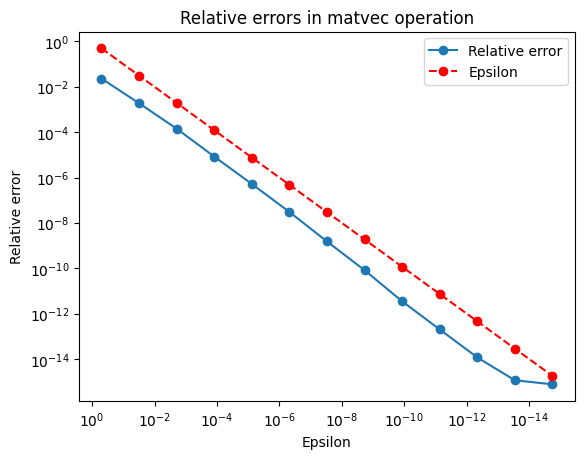

In [9]:
# Relative errors plot:
plt.plot(epsilons, errors, "o-", label="Relative error")
plt.plot(epsilons, epsilons, "or--", label="Epsilon")
plt.gca().invert_xaxis()
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Epsilon")
plt.ylabel("Relative error")
plt.title("Relative errors in matvec operation")
plt.legend()
plt.show()

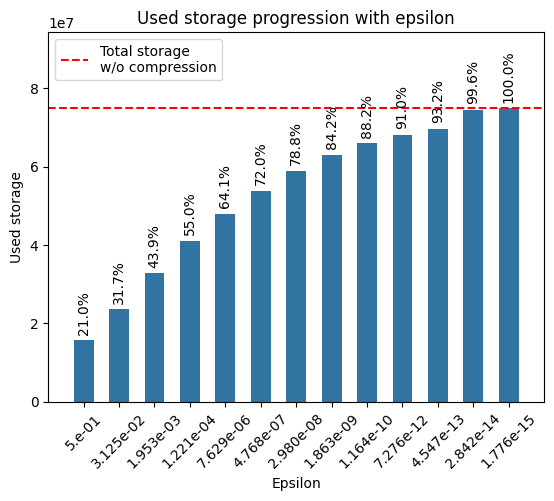

In [13]:
# Storage progession plot:
df = pd.DataFrame({"Used storage": used_storages, "Epsilon": formatted_epsilons})
ax = sns.barplot(df, x="Epsilon", y="Used storage", errorbar=None, gap=0.3)
bar_labels = np.round(np.asarray(used_storages) / total_storage_without_compression * 100, decimals=1)
ax.bar_label(ax.containers[0], fontsize=10, rotation=90, padding=4, labels=map(lambda x: f"{x}%", bar_labels))
xlim = plt.xlim()
xlim = (xlim[0] - 0.5, xlim[1] + 0.5)
plt.xlim(xlim)
plt.axhline(y=total_storage_without_compression, label="Total storage\nw/o compression", linestyle="--", color='r')
ylim = plt.ylim()
ylim = (ylim[0], ylim[1] * 1.2)
plt.ylim(ylim)
plt.title("Used storage progression with epsilon")
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()